# Lab-9 Template

Answer questions in the designated cells.

Rename notebook to include your name and NET-ID in the file name.
Submit two versions of your notebook:
- Original notebook
- HTML version. Make sure to produce Shapley plots using `matplotlib=True` option so that your plots are displayed in the HTML version
- Validate that all plots are displayed in the HTML version
- You can use `matplotlib=False` in the original version to get nicer plots

No need to encode missing values or categorical variables, other than make sure H2O recognizes them properly.
Use `asfactor` if need to correct encoding.

Use H2O to train models.

Resources: 
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb

Materials by Patrick Hall:
https://github.com/jphall663/interpretable_machine_learning_with_python
https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/debugging_resid_analysis_redux.ipynb   
Decision tree plotting: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb


## Preparation

Use dataset provided in the eLearning

In [1]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

In [2]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,25 mins 40 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,4 months and 11 days !!!
H2O_cluster_name:,H2O_from_python_srbuj_lvxuwg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.935 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


### Load data

In [3]:
train = h2o.import_file('Car_Prices_Poland_train.csv')
test = h2o.import_file('Car_Prices_Poland_test.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
train.head(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
opel,insignia,gen-a-2008-2017,2009,106125,1796,Gasoline,CzÄ™stochowa,ÅšlÄ…skie,25000
skoda,fabia,gen-ii-2007,2010,207000,1200,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900
opel,insignia,gen-a-2008-2017,2013,195000,1956,Diesel,Ruda ÅšlÄ…ska,ÅšlÄ…skie,24598
audi,a4,gen-b8-2007-2015,2012,280000,1968,Diesel,BiaÅ‚ystok,Podlaskie,41900
citroen,c4-picasso,gen-ii-2013-c4-picasso,2014,122200,1560,Diesel,Dziemionna,Kujawsko-pomorskie,39500


In [5]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (88445, 10)
Test shape: (29482, 10)


In [6]:
train.describe()

Rows:88445
Cols:10




,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
type,enum,enum,enum,int,int,int,enum,enum,enum,int
mins,,,,1964.0,0.0,0.0,,,,500.0
mean,,,,2012.933427553847,140832.01954887222,1812.3419074000788,,,,70347.49990389506
maxs,,,,2022.0,2800000.0,7600.0,,,,2399900.0
sigma,,,,5.684015918888904,92510.79953360026,646.7315007474648,,,,85275.90175596683
zeros,,,,0,283,936,,,,0
missing,0,0,22551,0,0,0,0,0,0,0
0,opel,insignia,gen-a-2008-2017,2009.0,106125.0,1796.0,Gasoline,CzÄ™stochowa,ÅšlÄ…skie,25000.0
1,skoda,fabia,gen-ii-2007,2010.0,207000.0,1200.0,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900.0
2,opel,insignia,gen-a-2008-2017,2013.0,195000.0,1956.0,Diesel,Ruda ÅšlÄ…ska,ÅšlÄ…skie,24598.0


In [7]:
# Choose which columns to encode

response = "price"
predictors = train.col_names[1:9]

predictors

['model',
 'generation_name',
 'year',
 'mileage',
 'vol_engine',
 'fuel',
 'city',
 'province']

## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='MAE',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [8]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [9]:
gbm_model = H2OGradientBoostingEstimator(nfolds = 5,
                                         ntrees = 500, 
                                         seed = 1234, 
                                         stopping_rounds = 5,
                                         stopping_metric = 'MAE',
                                         keep_cross_validation_predictions = False)

In [10]:
gbm_model.train(x = predictors,
               y = response,
               training_frame = train)

# retrieve the model performance
perf = gbm_model.model_performance(test)
perf

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 346348409.2635333
RMSE: 18610.43818032056
MAE: 8324.903599372014
RMSLE: NaN
Mean Residual Deviance: 346348409.2635333


In [11]:
prediction = gbm_model.predict(test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is most important feature?
- Can you tell how feature is impacting (direction) probability? 

In [12]:
permutation_varimp = gbm_model.permutation_importance(test, use_pandas=True)
permutation_varimp

,Relative Importance,Scaled Importance,Percentage
Variable,,,
model,43886.360792,1.000000,0.372493
year,43840.447701,0.998954,0.372104
mileage,11279.285635,0.257011,0.095735
vol_engine,8435.731859,0.192218,0.071600
generation_name,8327.711166,0.189756,0.070683
fuel,1245.718453,0.028385,0.010573
province,654.673838,0.014917,0.005557
city,147.911090,0.003370,0.001255


#### The most important feature is "model"

Predicting probabilities instead of class labels for a classification problem can provide additional uncertainty for the predictions.A feature may influence probability estimates without changing the predicted class label,scoring features according to their effect on probability estimates is more sensitive

## Question 3

Calculate absolute error percentage of the price on test dataset. Add absolute error column to the dataset and call it `abs_error`.   

Formula: `abs(price-predict_price)`

In [13]:
d = abs(response-prediction)
d

abs(predict)
1
1
1
1
1
1
1
1
1
1


In [14]:
test = test.cbind(d)
test

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,abs(predict)
skoda,octavia,gen-iii-2013,2016,63000,1598,Diesel,SzamotuÅ‚y,Wielkopolskie,49500,1
ford,mustang,,1967,1,6384,Gasoline,Å�Ã³dÅº,Å�Ã³dzkie,379900,1
mini,cooper,,2016,125600,1998,Gasoline,PoznaÅ„,Wielkopolskie,99800,1
hyundai,santa-fe,gen-iii-2012-santa-fe,2014,270000,2199,Diesel,RadziejÃ³w,Kujawsko-pomorskie,59900,1
renault,clio,gen-v-2019,2019,24000,999,Gasoline,Leszno,Wielkopolskie,56999,1
bmw,seria-3,gen-e46-1998-2007,2003,248000,2171,LPG,Åšwiebodzice,DolnoÅ›lÄ…skie,13900,1
volkswagen,tiguan,gen-ii-2016-tiguan,2018,26500,1498,Gasoline,SwarzÄ™dz,Wielkopolskie,117500,1
ford,mustang,,1966,47522,4700,Gasoline,Repki,Mazowieckie,59900,1
fiat,500,,2021,7,0,Electric,Warszawa,Mazowieckie,160000,1
volkswagen,caddy,gen-iv-2015,2021,10,1968,Diesel,Å�Ã³dÅº,Å�Ã³dzkie,140046,1


In [15]:
test.set_names(['mark','model','generation_name','year','mileage','vol_engine','fuel','city','province','price','abs_error'])

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,abs_error
skoda,octavia,gen-iii-2013,2016,63000,1598,Diesel,SzamotuÅ‚y,Wielkopolskie,49500,1
ford,mustang,,1967,1,6384,Gasoline,Å�Ã³dÅº,Å�Ã³dzkie,379900,1
mini,cooper,,2016,125600,1998,Gasoline,PoznaÅ„,Wielkopolskie,99800,1
hyundai,santa-fe,gen-iii-2012-santa-fe,2014,270000,2199,Diesel,RadziejÃ³w,Kujawsko-pomorskie,59900,1
renault,clio,gen-v-2019,2019,24000,999,Gasoline,Leszno,Wielkopolskie,56999,1
bmw,seria-3,gen-e46-1998-2007,2003,248000,2171,LPG,Åšwiebodzice,DolnoÅ›lÄ…skie,13900,1
volkswagen,tiguan,gen-ii-2016-tiguan,2018,26500,1498,Gasoline,SwarzÄ™dz,Wielkopolskie,117500,1
ford,mustang,,1966,47522,4700,Gasoline,Repki,Mazowieckie,59900,1
fiat,500,,2021,7,0,Electric,Warszawa,Mazowieckie,160000,1
volkswagen,caddy,gen-iv-2015,2021,10,1968,Diesel,Å�Ã³dÅº,Å�Ã³dzkie,140046,1


## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values? 
- Based on the Summary plot, how features `year` and `mileage` affect model precition of the car price?  

In [16]:
import shap
shap.initjs()

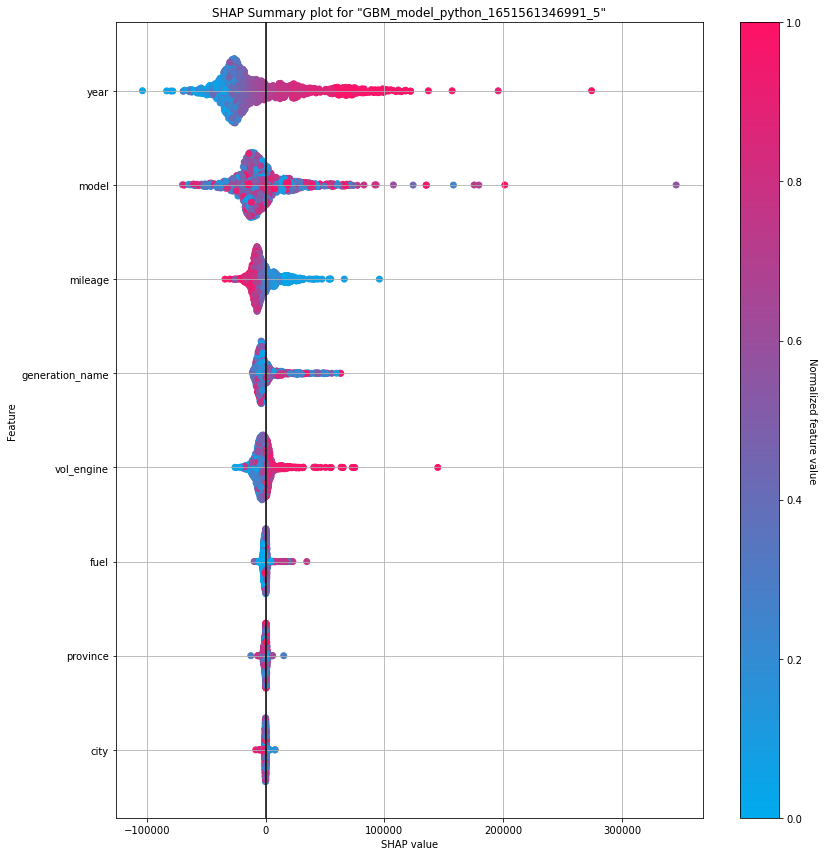

In [17]:
shap_plot = gbm_model.shap_summary_plot(test)

#### The most important feature based on shapley values is year.

As mileage increases (high mileage values have correspondingly low SHAP values),the prediction price decreases.
As year increases (increase in year values have correspondingly high SHAP values), the prediction price increases.

## Question 5

Plot individual Shapley values plots for records top 3 and bottom 3 records based on the residuals, for the total of 6 plots.  

Explain each plot in terms of what are most influential features and how they impact model prediction, and why you think model was correct for the top 3 records (smallest residuals) and significantly incorrect for the bottom 3 records (largest residuals).


In [18]:
contributions = gbm_model.predict_contributions(test)
contributions.sort

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


model,generation_name,year,mileage,vol_engine,fuel,city,province,BiasTerm
-9198.72,1062.63,967.197,4558.51,-7051.27,-2352.58,25.5783,-2205.27,70347.5
54337.5,-11835,19489.9,85749.6,188070,-209.341,2210.81,-3254.21,70347.5
661.51,-5606.71,7147.57,-3232.64,3979.4,292.918,598.783,-1819.28,70347.5
-2042.27,23963.9,-7839.23,-9411.21,588.158,1374.71,930.548,-1047.93,70347.5
-47848.9,-1692.42,36918.1,7405.08,-12382.6,405.598,-15.8009,-2073.58,70347.5
673.829,-2374.32,-47313.2,-9519.24,1544.87,-141.624,-617.704,-393.512,70347.5
-209.703,19873.1,24432.8,9162,-8871.52,-116.517,-429.621,-2182.76,70347.5
25584.5,-6364.33,-10504.3,8260.82,35113.4,-577.037,-2399.27,3815.37,70347.5
-46358.6,-3364.21,72559.7,20172.2,9800.61,15013.6,958.56,1434.34,70347.5
-26690.2,-1166.81,80960.3,20877.4,4321.34,-2688.37,1141.8,1867.82,70347.5


<bound method H2OFrame.sort of >

In [19]:
contributions_matrix = contributions.as_data_frame().to_numpy()

In [20]:
contributions_matrix_1 = contributions.as_data_frame()
# Calculate individual SHAP values for records 0,1 and 4
shap_values_1 = contributions_matrix_1.iloc[[0],:]
print(shap_values_1)
shap_values_2 = contributions_matrix_1.iloc[[1],:]
print(shap_values_2)
shap_values_3 = contributions_matrix_1.iloc[[2],:]
print(shap_values_3)
shap_values_4 = contributions_matrix_1.iloc[[29481],:]
print(shap_values_4)
shap_values_5 = contributions_matrix_1.iloc[[29480],:]
print(shap_values_5)
shap_values_6 = contributions_matrix_1.iloc[[29479],:]
print(shap_values_6)

         model  generation_name        year      mileage  vol_engine  \
0 -9198.717773      1062.627686  967.197021  4558.509277 -7051.27002   

          fuel       city     province  BiasTerm  
0 -2352.583496  25.578333 -2205.268799   70347.5  
          model  generation_name          year       mileage    vol_engine  \
1  54337.480469    -11834.991211  19489.935547  85749.617188  188070.21875   

         fuel         city     province  BiasTerm  
1 -209.340897  2210.806396 -3254.205811   70347.5  
        model  generation_name         year     mileage   vol_engine  \
2  661.510437     -5606.708984  7147.572266 -3232.64209  3979.397217   

         fuel        city    province  BiasTerm  
2  292.917694  598.782715 -1819.28479   70347.5  
              model  generation_name          year     mileage   vol_engine  \
29481 -15352.480469     -5752.242188 -12415.204102 -209.199249 -4289.978516   

             fuel       city  province  BiasTerm  
29481  375.982391  63.499561 -8.91803

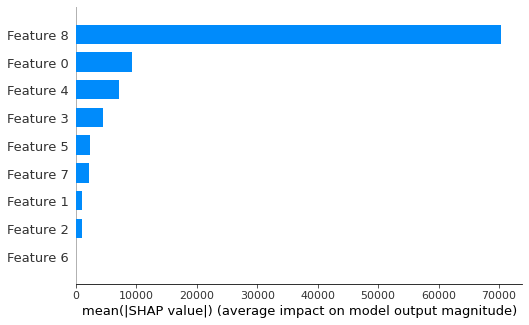

In [21]:
shap.summary_plot(shap_values_1,plot_type="bar")

The most influential features for record 3 are Feature 8, Feature 0, Feature 4

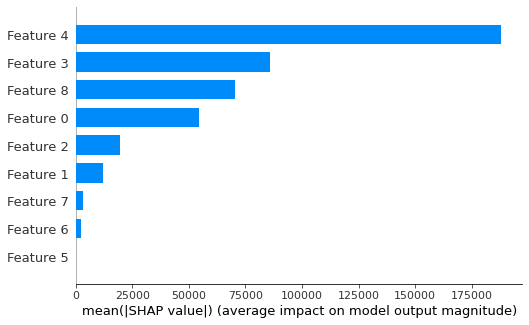

In [22]:
shap.summary_plot(shap_values_2,plot_type="bar")

The most influential features for record 3 are Feature 4, Feature 3, Feature 8

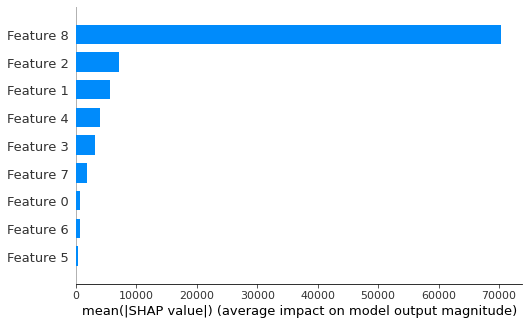

In [23]:
shap.summary_plot(shap_values_3,plot_type="bar")

The most influential features for record 3 are Feature 8, Feature 2, Feature 1

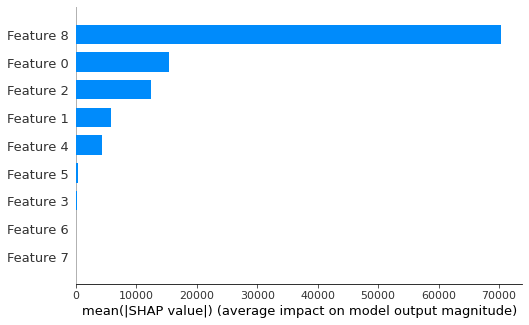

In [24]:
shap.summary_plot(shap_values_4,plot_type="bar")

The most influential features for record 3 are Feature 8, Feature 0, Feature 2

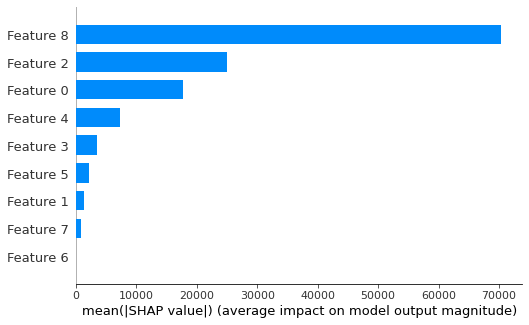

In [25]:
shap.summary_plot(shap_values_5,plot_type="bar")

The most influential features for record 3 are Feature 8, Feature 2, Feature 0

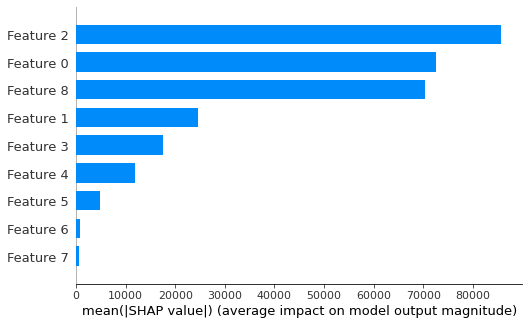

In [26]:
shap.summary_plot(shap_values_6,plot_type="bar")

The most influential features for record 3 are Feature 2, Feature 0, Feature 8

## Question 6 

Train new H2O GBM model on the test dataset trying to predict residuals. This is your surrogate modedel that you will use to understand what features are driving high residuals.   

Use same parameters as in question #1, except:
  - predictor is now "abs_error"
  - dataset now is "test" dataset
  - make sure not to include original "price" column in the model

Plot Shapley summary plot for the top 100 records with highest residuals.
Answer following question:
  - What is the most important feature of the surrogate model that impacts high residuals?

In [27]:
gbm_model1 = H2OGradientBoostingEstimator(nfolds = 5,
                                         ntrees = 500, 
                                         seed = 1234, 
                                         stopping_rounds = 5,
                                         stopping_metric = 'MAE',
                                         keep_cross_validation_predictions = False)

In [28]:
gbm_model1.train(x = ["mark","model","generation_name","year","mileage","vol_engine","fuel","city","province","abs_error"],
               y = "price",
               training_frame = test)


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1651561346991_6


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,118.0,118.0,106575.0,5.0,5.0,5.0,9.0,32.0,25.084745




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 202022344.2236146
RMSE: 14213.45644885911
MAE: 7275.723390431589
RMSLE: 0.17719228650894084
Mean Residual Deviance: 202022344.2236146

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 418888672.26115286
RMSE: 20466.769951830523
MAE: 9082.248630682927
RMSLE: 0.2045165792862677
Mean Residual Deviance: 418888672.26115286

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,9.083353e+03,1.762940e+02,9.157498e+03,9.296856e+03,9.121868e+03,8.823933e+03,9.016609e+03
1,mean_residual_deviance,4.192545e+08,4.352190e+07,3.986352e+08,4.724041e+08,3.704067e+08,3.973520e+08,4.574744e+08
2,mse,4.192545e+08,4.352190e+07,3.986352e+08,4.724041e+08,3.704067e+08,3.973520e+08,4.574744e+08
3,r2,9.398656e-01,5.325803e-03,9.435769e-01,9.347860e-01,9.448885e-01,9.426196e-01,9.334573e-01
4,residual_deviance,4.192545e+08,4.352190e+07,3.986352e+08,4.724041e+08,3.704067e+08,3.973520e+08,4.574744e+08
5,rmse,2.045380e+04,1.058603e+03,1.996585e+04,2.173486e+04,1.924595e+04,1.993369e+04,2.138865e+04
6,rmsle,2.045142e-01,2.869815e-03,2.047893e-01,2.008215e-01,2.047093e-01,2.034795e-01,2.087713e-01



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-05-03 02:31:25,4.945 sec,0.0,83455.831020,53983.400551,6.964876e+09
1,,2022-05-03 02:31:25,4.955 sec,1.0,76060.243369,49073.800323,5.785161e+09
2,,2022-05-03 02:31:25,4.963 sec,2.0,69412.930476,44572.535558,4.818155e+09
3,,2022-05-03 02:31:25,4.968 sec,3.0,63517.310303,40675.156587,4.034449e+09
4,,2022-05-03 02:31:25,4.968 sec,4.0,58200.710326,37066.248577,3.387323e+09
5,,2022-05-03 02:31:25,4.988 sec,5.0,53444.774303,33807.888267,2.856344e+09
6,,2022-05-03 02:31:25,4.997 sec,6.0,49185.638710,30918.485820,2.419227e+09
7,,2022-05-03 02:31:25,5.005 sec,7.0,45378.487020,28308.188147,2.059207e+09
8,,2022-05-03 02:31:25,5.014 sec,8.0,42055.465932,25980.852412,1.768662e+09
9,,2022-05-03 02:31:25,5.022 sec,9.0,39089.600834,23939.473411,1.527997e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,year,4.648628e+14,1.000000,0.442997
1,model,4.447249e+14,0.956680,0.423807
2,generation_name,6.455978e+13,0.138879,0.061523
3,vol_engine,3.884523e+13,0.083563,0.037018
4,mileage,2.671739e+13,0.057474,0.025461
5,province,6.074208e+12,0.013067,0.005788
6,fuel,2.345376e+12,0.005045,0.002235
7,city,1.174764e+12,0.002527,0.001120
8,mark,5.338132e+10,0.000115,0.000051


In [29]:
contributions1 = gbm_model1.predict_contributions(test)
contributions1.sort

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,BiasTerm
1.5452,-10156.5,-1240,2508.61,4954.3,-5175.19,-1400.72,-270.915,-1207.5,70157
-89.4456,85912.4,-1089.35,44449.9,55968.8,178777,-454.163,77.3985,2987.73,70157
-0.755296,3747.32,-3974.44,8027.75,-238.103,6011.83,211.717,415.747,-1672.54,70157
-0.863895,-5268.58,12370.8,-8569.7,-10140.9,646.047,618.911,192.84,161.752,70157
8.78775,-52259.9,-1221.94,38995.2,5831.78,-8336.75,-786.729,81.0233,-1611,70157
-5.15083,-171.804,-6620.44,-44754.2,-8152.74,1044.45,-220.727,-841.386,361.112,70157
0.956546,-2091.73,23329.1,16577.4,9352.75,-6225.42,-869.072,230.046,-2267.04,70157
21.3931,23489.2,-5052.62,381.906,12693.3,35362.6,-1160.92,-637.552,1205.97,70157
-38.2424,-48834.1,-2879.69,81210.8,17706.6,4230.69,19689.2,-7.56637,4419.48,70157
1.11708,-21149.7,-1363.12,88771.8,18599.2,3419.53,-693.093,-27.1734,1759.86,70157


<bound method H2OFrame.sort of >

In [30]:
contributions_matrix1 = contributions1.as_data_frame().to_numpy()

In [31]:
contribution_matrix1 = contributions1.as_data_frame()


In [32]:
# Calculate SHAP values for all features
shap_val = contributions_matrix1[1:100,0:9]
shap_val

array([[-8.94456100e+01,  8.59123984e+04, -1.08934924e+03,
         4.44498789e+04,  5.59687930e+04,  1.78777125e+05,
        -4.54163239e+02,  7.73984985e+01,  2.98772803e+03],
       [-7.55295873e-01,  3.74731519e+03, -3.97444385e+03,
         8.02775391e+03, -2.38103424e+02,  6.01182910e+03,
         2.11717300e+02,  4.15746948e+02, -1.67253650e+03],
       [-8.63895118e-01, -5.26858496e+03,  1.23707529e+04,
        -8.56969824e+03, -1.01408936e+04,  6.46047241e+02,
         6.18910583e+02,  1.92839813e+02,  1.61752319e+02],
       [ 8.78775406e+00, -5.22598828e+04, -1.22194299e+03,
         3.89951836e+04,  5.83178027e+03, -8.33675391e+03,
        -7.86729431e+02,  8.10232773e+01, -1.61099585e+03],
       [-5.15083313e+00, -1.71803589e+02, -6.62044092e+03,
        -4.47541992e+04, -8.15274121e+03,  1.04444861e+03,
        -2.20726929e+02, -8.41385620e+02,  3.61112305e+02],
       [ 9.56546068e-01, -2.09173413e+03,  2.33290820e+04,
         1.65774277e+04,  9.35274902e+03, -6.225415

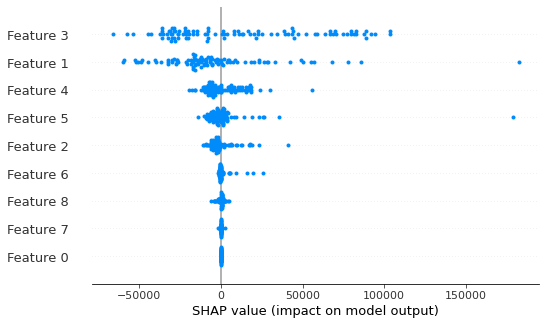

In [33]:
shap.summary_plot(shap_val)

Feature 3 drives highest residuals

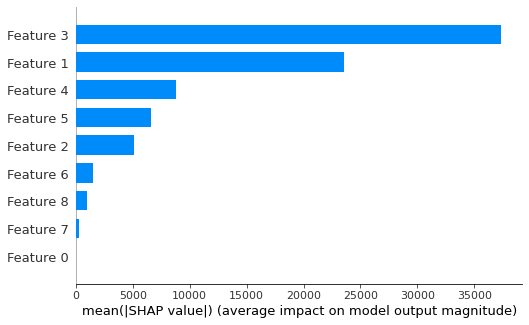

In [34]:
shap.summary_plot(shap_val,plot_type="bar")

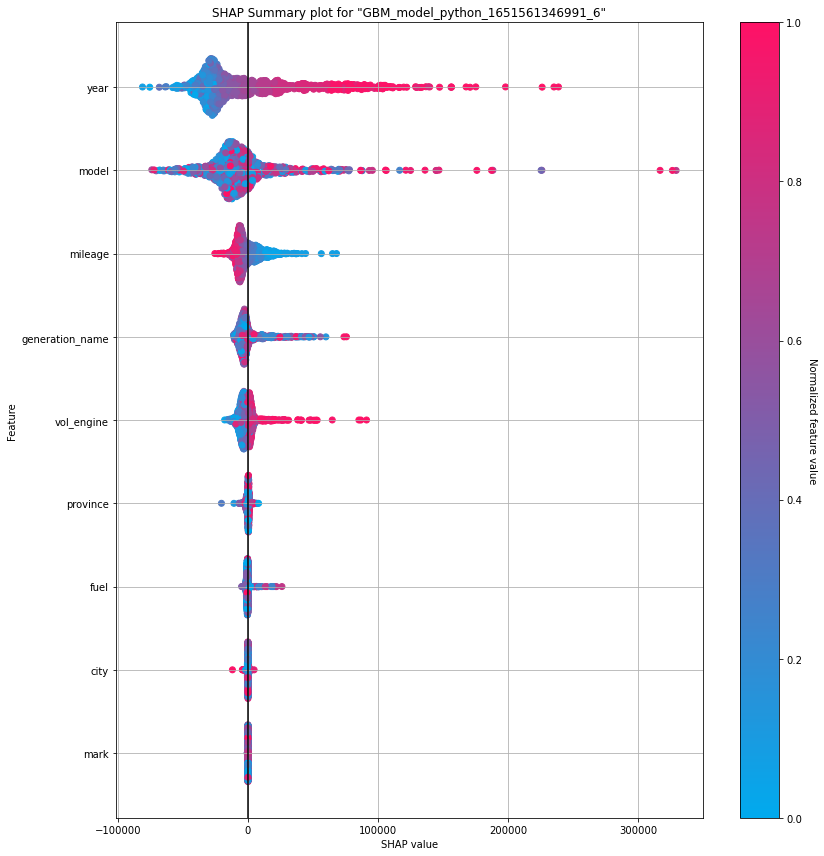

In [35]:
shapley_plot = gbm_model1.shap_summary_plot(test)